# Supplemental Data Exploration
##### Author: Alex Oesterling
Summary: The supplemental data has additional text features such as full text of papers which we do not have access to for the competition. In addition, **the citation context is much larger (4-5 sentences) rather than the 1-2 we get for the competition** as well. However, we are given similar cited author + cited title information. 

Each json file has a tokenized version of the full text in addition to "citation contexts," which is a list of all citations and their necessary info/context in the paper. **Only a few per paper have labels in the form of "citation function" which represents our 6 classes.** There is nothing on influential/incidental citations, and the competition seems to be synthesizing the results of this paper with the incidental/influential paper also cited in the competition writeup. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import random

In [2]:
files_to_process = []
data_dir = "../../Data/Supplemental"
for fname in os.listdir(data_dir):
    if fname.endswith(".json"):
        files_to_process.append(fname)

Here I plot a random sample from the dataset. Note that not all citations in the dataset are annotated for "citation function" (our multiclass label) and we may be able to gather information from them or add labels to them.

In [3]:
classes = {"Background" : [],  "CompareOrContrast" : [], "Extends" : [], "Future" : [], "Motivation" : [], "Uses" : []}

def map_label(string):
    return ["Background", "CompareOrContrast", "Extends", "Future", "Motivation", "Uses"].index(string)

def filter_context(context, author, verbose=False):
    tokens = context.split(". ")
    if verbose:
        print(tokens)
        print(author)
    for i, sentence in enumerate(tokens):
        if author in sentence:
            out = sentence.replace("(" + author, "#AUTHOR_TAG")
            out = out.replace(author, "#AUTHOR_TAG")
            return ". ".join([tokens[i-1], out])

sample = random.randint(1, 100)
sampleindex = 0
for file in files_to_process:
    f = open(data_dir + "/" + file)
    data = json.load(f)
    for index, entry in enumerate(data["citation_contexts"]):
        if "citation_function" in entry.keys():
            entrydict = {}
            entrydict["unique_id"] = None
            entrydict["core_id"] = data["paper_id"]
            entrydict["citing_title"] = None
            entrydict["citing_author"] = None
            entrydict["cited_author"] = entry["info"]["authors"][0]
            entrydict["cited_title"] = entry["info"]["title"]
            authortokens = entry["info"]["authors"][0].split(" ")
            authortokens.reverse()
            entrydict["citation_context"] = filter_context(entry["cite_context"], authortokens[0])
            entrydict["citation_class_label"] = map_label(entry["citation_function"])
            entrydict["citation_influence_label"] = None
            classes[entry["citation_function"]].append(entrydict)
            sampleindex+=1
            if sampleindex == sample:
                print(entry["citation_function"])
                print(entry["info"]["authors"])
                print(entry["cite_context"])
                print("==================TRIMMED CITATION==============")
                print(filter_context(entry["cite_context"], authortokens[0]))
                break

Uses
['R Moore', 'J Dowding', 'H Bratt', 'J Gawron']
nitor other environmental functions. In particular, our simulation allows voice access to the current and past values of the fixed sensor readings. The initial PSA speech interface demo consists of a simple simulation of the Shuttle. State parameters include the PSA's current position, some environmental variables such as local temperature, pressure and carbon dioxide levels, and the status of the Shuttle's doors (open/closed). A visual display gives direct feedback on some of these parameters. 113 The speech and language processing architecture is based on that of the SRI CommandTalk system (Moore et al., 1997; Stent et a., 1999). The system comprises a suite of about 20 agents, connected together using the SRI Open Agent Architecture (OAA; (Martin et al., 1998)). Speech recognition is performed using a version of the Nuance recognizer (Nuance, 2000). Initial language processing is carried out using the SRI Gemini system (Dowding et

Text(0.5, 1.0, 'Multiclass Label Distribution, Supplementary Dataset')

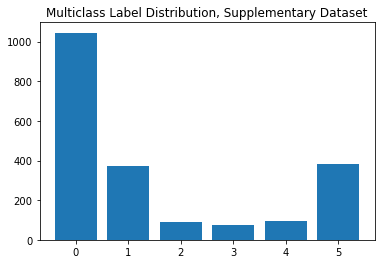

In [4]:
hist = [len(classes[i]) for i in classes.keys()]
x = np.arange(6)
plt.bar(x, hist)
plt.title("Multiclass Label Distribution, Supplementary Dataset")

As we can see, similar to the sample dataset, the multiclass label distribution has a high class imalance towards 0 (Background) and to a lesser extent 5 (Uses). This distribution almost identically mirrors the distribution found in the given training data, which makes me wonder how related the datasets are.

I think using SMOTE to oversample classes 1-4 is our best bet to patch up this class imbalance.

Another alternative is to take only classes 1-4 from here and add them to our total training pool to supplement the weaker classes.

In [5]:
finaldict = {}
for i in classes["Background"][0].keys():
    finaldict[i] = []
for i in classes.keys():
    for j in classes[i]:
        for k in j.keys():
            finaldict[k].append(j[k])
df = pd.DataFrame(finaldict, columns=finaldict.keys())
df.head()
df.to_csv(data_dir+'/../supplemental.csv', index = False)

I reformatted the data into a csv for use with our main training pool and saved it in the "Supplemental" folder.